In [42]:
import datetime, time
import netCDF4
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
class particle_tracking():
    """
    Particle tracking function
    EF is euler foreward scheme
    RK4 is  the Runge-Kutta scheme after: 
    https://nl.wikipedia.org/wiki/Runge-Kuttamethode
    for the interpolation between gridpints the nearest-point method is used.
    
    This method assumes:
    - rectangular or curvilinear grid
    - WGS84 coordinates
    
    the WGS84 transformation is done with the method presented in:
    https://en.wikipedia.org/wiki/Geographic_coordinate_system
    
    the class flow should contain:
    - x,y,t as a numpy meshgrid (y, x, t = np.meshgrid(y, x, t))
    - u, v
    - u.shape = v.shape = x.shape = y.shape = t.shape
    """
    
    def __init__(self, flow):
        """Initialis the class with the input data"""
        self.flow = flow


        
    def EF(self, x0, y0, T):
        """This method finds the path with the Euler foreward scheme"""
        self.x0 = x0
        self.y0 = y0
        self.T = T
        self.dt = self.T[1] - self.T[0]
        
        lat = y0 * 2* np.pi / 360
        self.mdeg_lat = 111132.92\
                        - 559.82 * np.cos(2*lat)\
                        + 1.175 * np.cos(4*lat)\
                        - 0.0023 * np.cos( 6 * lat)
        self.mdeg_lon = 111412.84 * np.cos(lat)\
                        - 93.5 * np.cos(3*lat)\
                        + 0.118 * np.cos(5*lat)
        x = [self.x0]
        y = [self.y0]
        for t in self.T:
            if t > self.flow.t[-1] or t < self.flow.t[0]:
                print('time out of range of the hydrodynamic model')
                break
            else:
                x0, y0 = self.numeric_scheme_EF(x0,y0,t)
                x.append(x0)
                y.append(y0)
        return x, y
    
    def RK4(self, x0, y0, T):
        """ This method finds the path with the RK4 scheme"""
        self.x0 = x0
        self.y0 = y0
        self.T = T
        self.dt = self.T[1] - self.T[0]
        
        lat = y0 * 2* np.pi / 360
        self.mdeg_lat = 111132.92\
                        - 559.82 * np.cos(2*lat)\
                        + 1.175 * np.cos(4*lat)\
                        - 0.0023 * np.cos( 6 * lat)
        self.mdeg_lon = 111412.84 * np.cos(lat)\
                        - 93.5 * np.cos(3*lat)\
                        + 0.118 * np.cos(5*lat)
        
        x = [self.x0]
        y = [self.y0]
        for t in self.T:
            if t > self.flow.t[-1] or t < self.flow.t[0]:
                print('time out of range of the hydrodynamic model')
                break
            else:
                x0, y0 = self.numeric_scheme_RK4(x0,y0,t)
                x.append(x0)
                y.append(y0)
        return x, y      
        
    def numeric_scheme_EF(self, x, y, t):
        """This method contains the euler foreward sheme"""
        u, v = self.interpol(x, y, t)
        
        x = x + self.dt * u  / self.mdeg_lon
        y = y + self.dt * v  / self.mdeg_lat
        
        return x,y
    
    def numeric_scheme_RK4(self, x, y, t):
        """This method contains the RK4 sheme"""

        u0, v0 = self.interpol(x,
                               y,
                               t,
                              )
        K1_x =  self.dt * u0 / self.mdeg_lon
        K1_y =  self.dt * v0 / self.mdeg_lat
        
        u1, v1 = self.interpol(x+K1_x/2,
                               y+K1_y/2,
                               t + self.dt/2, 
                              )
        K2_x = self.dt * u1 / self.mdeg_lon
        K2_y = self.dt * v1 / self.mdeg_lat
        
        u2, v2 = self.interpol(x+K2_x/2,
                               y+K2_y/2,
                               t + self.dt/2, 
                              )
        K3_x = self.dt * u2 / self.mdeg_lon
        K3_y = self.dt * v2 / self.mdeg_lat
        
        u3, v3 = self.interpol(x+K3_x,
                               y+K3_y,
                               t + self.dt, 
                              )
        K4_x = self.dt * u3 / self.mdeg_lon
        K4_y = self.dt * v3 / self.mdeg_lat
 
        x = x + (1/6)*(K1_x + K2_x + K3_x + K4_x)
        y = y + (1/6)*(K1_y + K2_y + K3_y + K4_y)
        
        return x,y
    
    def interpol(self, x, y, t):
        """ this function returns the specific flow condtions 
        for a given point in space and time"""
        DD = (self.flow.x[:,:] - x) ** 2 + (self.flow.y[:,:] - y)** 2 
        i = np.argwhere(DD == DD.min())[0]
        TT = (self.flow.t - t)**2
        ii = np.argwhere(TT == TT.min())[0,0]
       
        return self.flow.u[ii, i[0], i[1]], self.flow.v[ii, i[0], i[1]]

In [3]:
def func(name):
    nc = netCDF4.Dataset('G:/Validatiecase TEXEL data/{}.nc'.format(name))

    x_domain = (250, 400)  # general-waddden sea (250, 380)
    y_domain = (450, 760)  # (530,760)

    v = nc.variables["VELV"][:, :, :]
    u = nc.variables["VELU"][:, :, :]
    x = nc.variables["x"][:, :]
    y = nc.variables["y"][:, :]
    t = nc.variables["time"][:]
    t = t * 60
    x = x[x_domain[0] : x_domain[1], y_domain[0] : y_domain[1]]
    y = y[x_domain[0] : x_domain[1], y_domain[0] : y_domain[1]]
    u = u[:, x_domain[0] : x_domain[1], y_domain[0] : y_domain[1]]
    v = v[:, x_domain[0] : x_domain[1], y_domain[0] : y_domain[1]]
    
    return x,y,t,u,v

In [4]:
class flow_zuno():  # testcasae with rotating flow with tidal component
    def __init__(self): 
        number_downloads = 10
        t0 = '08/05/2018 06:00:00'
        t0 = datetime.datetime.strptime(t0, "%d/%m/%Y %H:%M:%S").timestamp()
        names = []
        for i in range(number_downloads):
            ana = datetime.datetime.fromtimestamp(t0+i*60*60*6).strftime('%Y%m%d%H%M')
            names.append(ana)
        
        x,y,t,u,v = func(names[0])
        for i in range(1, len(names)):
            x,y,t1,u1,v1 = func(names[i])        
            t = np.concatenate((t,t1))
            u = np.concatenate((u,u1))
            v = np.concatenate((v,v1))
        
        self.u = u
        self.v = v
        self.x = x
        self.y = y
        self.t = t

In [5]:
f = flow_zuno()

In [6]:
y0, x0 = 52.999657, 4.892105
T = f.t[1:-1]

start = time.time()
pt = particle_tracking(f)
stop = time.time()
print('computation time is',np.round(stop - start,2))

EF = pt.EF(x0, y0, T)
RK4 = pt.RK4(x0, y0, T)

computation time is 0.0


computation time is 0.0
computation time is 0.0


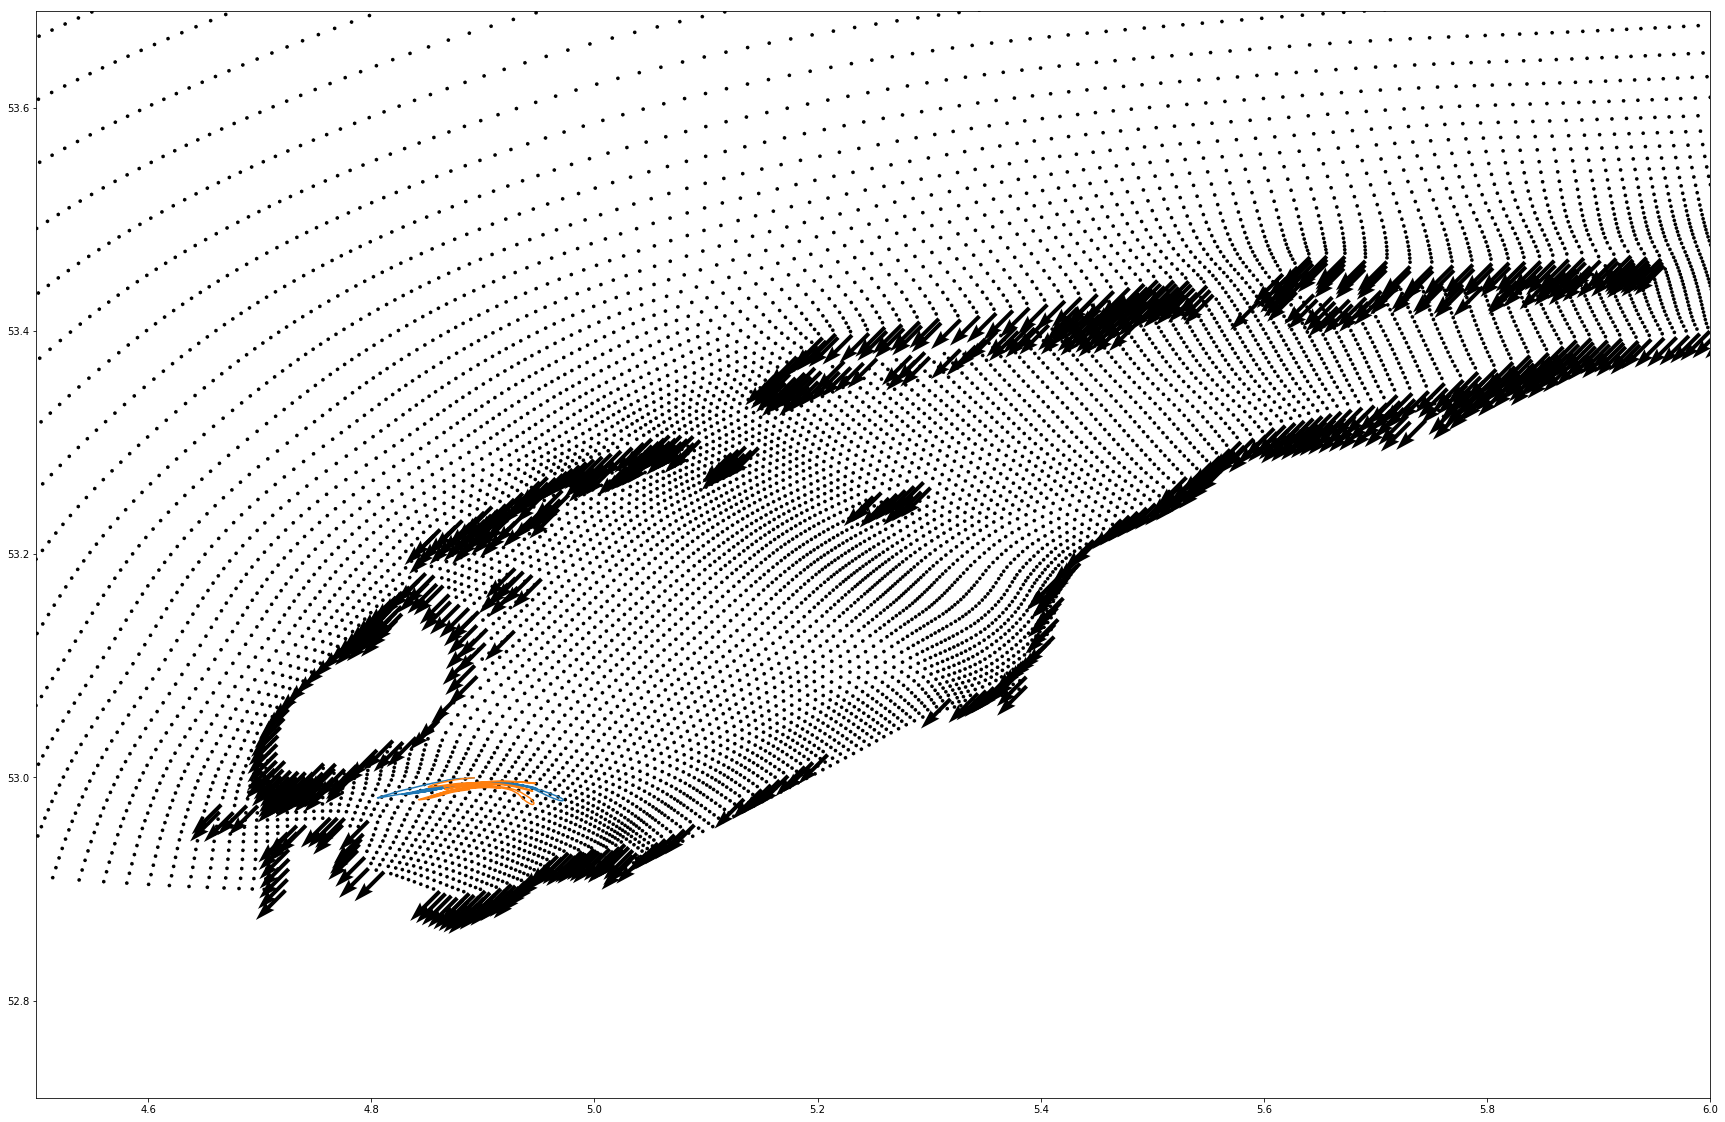

In [7]:
% matplotlib inline

fig = plt.figure(figsize=(30,20))
ax = plt.subplot()
ax.axis('equal')

plt.xlim(4.5,6)
plt.ylim(52.9,53.5)

a = 2

plt.quiver(f.x[::a,::a],
           f.y[::a,::a],
           f.u[0,::a,::a],
           f.v[0,::a,::a]
          )

start = time.time()
plt.plot(EF[0], EF[1])
stop = time.time()
print('computation time is',np.round(stop - start,2))

start = time.time()
plt.plot(RK4[0], RK4[1])
stop = time.time()
print('computation time is',np.round(stop - start,2))

plt.show()

In [8]:
T = f.t[1:-1]

y0, x0 = 52.999657, 4.892105
x,y = pt.RK4(x0, y0, T)

y0, x0 = 53.324300, 5.138643
x2,y2 = pt.RK4(x0, y0, T)

<IPython.core.display.Javascript object>


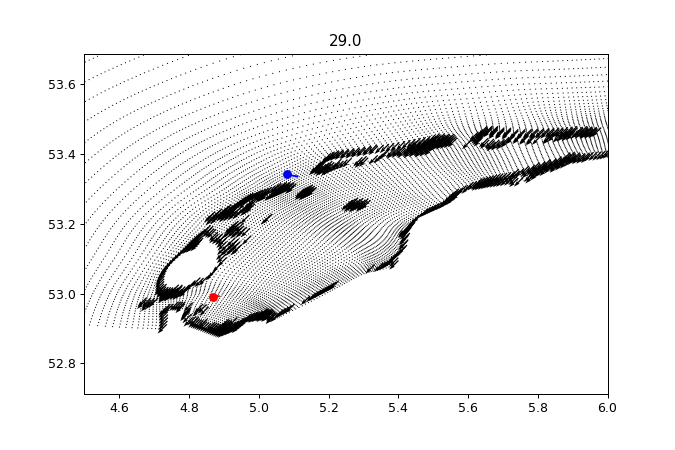

MovieWriter ffmpeg unavailable.


In [56]:
import matplotlib.animation as animation
% matplotlib notebook

fig = plt.figure(figsize=(7.5,5))
ax = plt.subplot()
ax.axis('equal')

plt.xlim(4.5,6)
plt.ylim(52.9,53.5)

a = 2

q = plt.quiver(f.x[::a,::a],
               f.y[::a,::a],
               f.u[0,::a,::a],
               f.v[0,::a,::a],
               pivot='mid'
          )


l1, = plt.plot([],[], 'r')
l2, = plt.plot([],[],'ro')

l3, = plt.plot([],[], 'b')
l4, = plt.plot([],[],'bo')

def update_line(i, l1, l2,l3,l4, q):
    QQ = 10
    i = i*1
    Q = int((i)/(len(f.t[:])))
    i = i - Q * (len(f.t[:]))
    plt.title(np.round((f.t[i] - f.t[0])/ 3600 ,1) )
    l1.set_data(x[i:i+QQ], y[i:i+QQ])
    l2.set_data(x[i+QQ], y[i+QQ])
    
    l3.set_data(x2[i:i+QQ], y2[i:i+QQ])
    l4.set_data(x2[i+QQ], y2[i+QQ])
    
    q.set_UVC(f.u[i,::a,::a],
              f.v[i,::a,::a]
          )
    
    return l1, l2,l3,l4, q
    
ani = animation.FuncAnimation(fig, 
                              update_line,
                              len(f.t) - 11,
                              fargs=[l1, l2, l3,l4, q], 
                              interval=20,
                              repeat = True
                             )

# ani.save('gif{}.gif'.format(int(time.time())))

In [43]:
start = time.time()

N = 20
point_x = np.linspace(4.5,6,N)
point_y = np.linspace(52.9,53.5,N)

point_x, point_y = np.meshgrid(point_x,point_y)
point_x = point_x.reshape(point_x.size)
point_y = point_y.reshape(point_y.size)

T = f.t[1:-1]
x_g = []
y_g = []

for i in range(len(point_x)):
    y0, x0 = point_y[i], point_x[i]
    x_t,y_t = pt.RK4(x0, y0, T)
    x_g.append(x_t)
    y_g.append(y_t)
    
    clear_output(wait = True)
    print(np.round((i+1)/len(point_x) * 100,2), '%')
    
y_g = np.array(y_g)
x_g = np.array(x_g)

stop = time.time()
print('computation time is',np.round(stop - start,2))

100.0 %
computation time is 4121.31


<IPython.core.display.Javascript object>


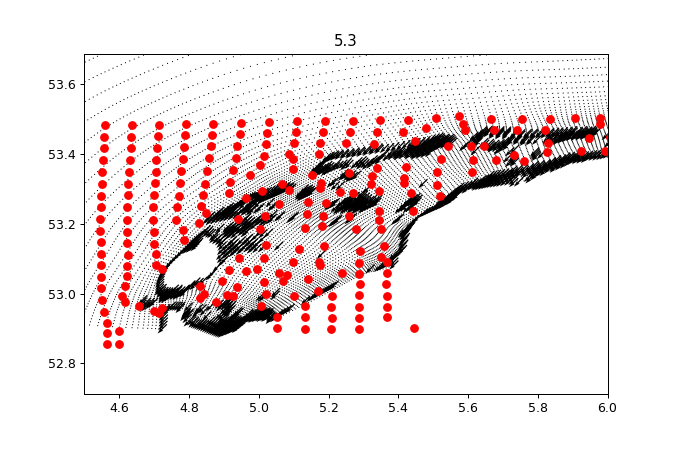

MovieWriter ffmpeg unavailable.


In [57]:
import matplotlib.animation as animation
% matplotlib notebook

fig = plt.figure(figsize=(7.5,5))
ax = plt.subplot()
ax.axis('equal')

plt.xlim(4.5,6)
plt.ylim(52.9,53.5)

a = 2

q = plt.quiver(f.x[::a,::a],
               f.y[::a,::a],
               f.u[0,::a,::a],
               f.v[0,::a,::a],
               pivot='mid'
          )


l1, = plt.plot([],[], 'ro')


def update_line(i, l1, q):
    i = i*1
    Q = int((i)/(len(f.t[:])))
    i = i - Q * (len(f.t[:]))
    plt.title(np.round((f.t[i] - f.t[0])/ 3600 ,1) )
    l1.set_data(x_g[:,i], y_g[:,i])

    
    q.set_UVC(f.u[i,::a,::a],
              f.v[i,::a,::a]
          )
    
    return l1, q
    
ani = animation.FuncAnimation(fig, 
                              update_line,
                              len(f.t) - 1,
                              fargs=[l1, q], 
                              interval=100,
                             )

# ani.save('gif{}.gif'.format(int(time.time())))

In [64]:
import cartopy

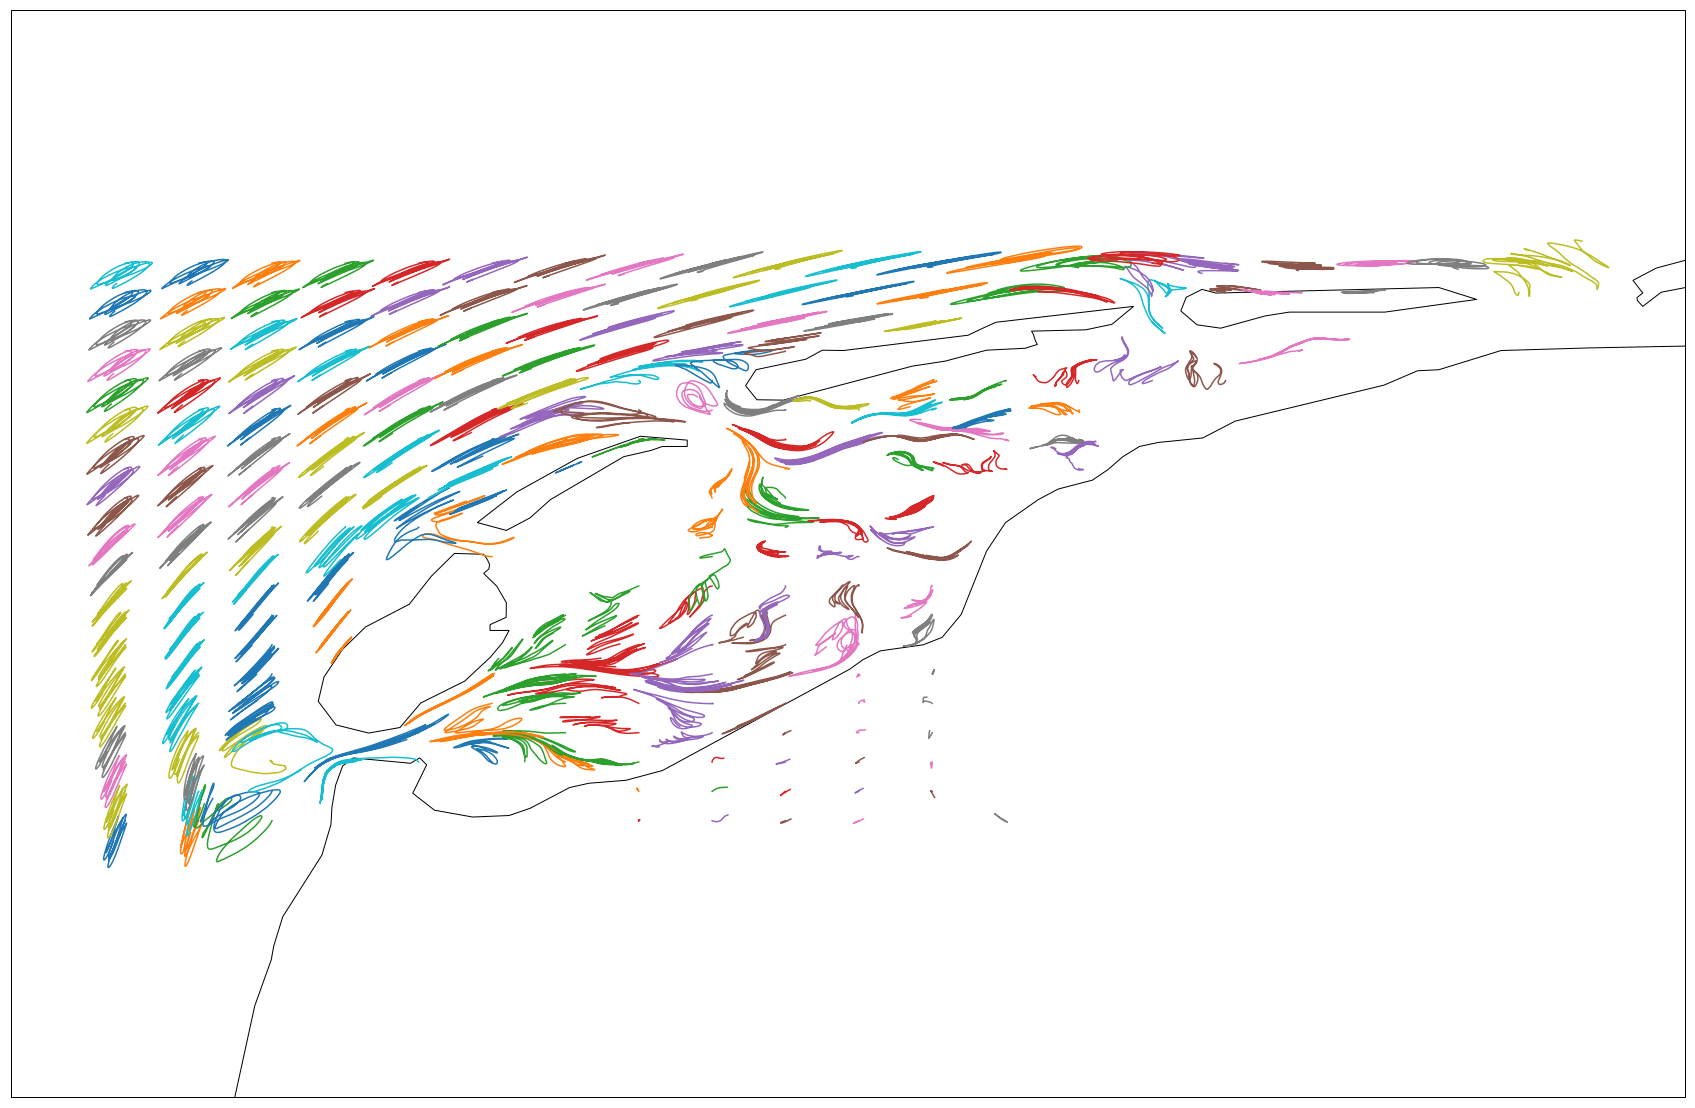

In [73]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(30,20))
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.axis('equal')
ax.coastlines(resolution= '10m')

for i in range(x_g.shape[0]):
    if x_g[i].min() > 0:
        plt.plot(x_g[i], y_g[i])